In [12]:
! pip install pmdarima

     |████████████████████████████████| 595 kB 248 kB/s            
     |████████████████████████████████| 17.6 MB 1.6 MB/s            
     |████████████████████████████████| 9.6 MB 202 kB/s            
     |████████████████████████████████| 233 kB 1.6 MB/s            
     |████████████████████████████████| 40 kB 1.3 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.1
    Uninstalling patsy-0.5.1:
      Successfully uninstalled patsy-0.5.1
  Attempting uninstall: packaging
    Found existing installation: packaging 20.4
    Uninstalling packaging-20.4:
      Successfully uninstalled packaging-20.4
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.0
    Uninstalling statsmodels-0.12.0:
      Successfully uninstalled statsmodels-0.12.0
You should consider upgra

In [28]:
import pandas as pd
from binance.client import Client
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

# client configuration
api_key = 'API HERE'
api_secret = 'SECRET API HERE'
client = Client(api_key, api_secret)


Data - BTCUSD, interval 1d, March 1, 2021 - March 9, 2022.

2021-03-02 07:59:59.999    49607.00
2021-03-03 07:59:59.999    48454.09
2021-03-04 07:59:59.999    50400.00
2021-03-05 07:59:59.999    48323.38
2021-03-06 07:59:59.999    48757.79
                             ...   
2022-03-05 07:59:59.999    39152.61
2022-03-06 07:59:59.999    39406.50
2022-03-07 07:59:59.999    38401.61
2022-03-08 07:59:59.999    38053.84
2022-03-09 07:59:59.999    38843.78
Name: close, Length: 373, dtype: float64

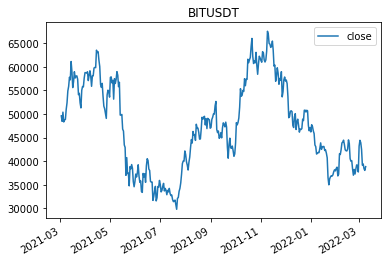

In [43]:
symbol = "BTCTUSD"
interval= '1d'
Client.KLINE_INTERVAL_1DAY
klines = client.get_historical_klines(symbol, interval, "1 Mar,2021")
data = pd.DataFrame(klines)
 # create colums name
data.columns = ['open_time','open', 'high', 'low', 'close', 'volume','close_time', 'qav','num_trades','taker_base_vol','taker_quote_vol', 'ignore']

# change the timestamp
data.index = [dt.datetime.fromtimestamp(x/1000.0) for x in data.close_time]
data.to_csv(symbol+'.csv', index = None, header=True)
#convert data to float and plot
df=data.astype(float)
df["close"].plot(title = 'BITUSDT', legend = 'close')
dates = df.index[1:]
close = df['close']
close
#info = client.get_all_tickers()
#info


In [30]:
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Function to conduct ADF test, aka. stationary test
def adf(ts):
    result = adfuller(ts)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
adf(df['close']) # Close price ts is clearly non-stationary.

ADF Statistic: -1.7706546883080017
p-value: 0.3951250424839655
Critical Values:
	1%: -3.4480516066132636
	5%: -2.869340997473759
	10%: -2.5709257824604


Usually for financial or economic data, first-order differencing and log transformation are sufficient for make ts
stationary. More complex transformation is the Box-Cox transformation. As we disscussed eariler, the traditional
transformation doesn't work on this ts. Further we try Box-Cox, the result is not promising either (transformation and
results are in the end). It is impossible for a valid ARIMA without a staionary ts. Thus we turn to study daily percentage
return.

ADF Statistic: -20.19509889727475
p-value: 0.0
Critical Values:
	1%: -3.4480996560263386
	5%: -2.8693621113224137
	10%: -2.570937038891028


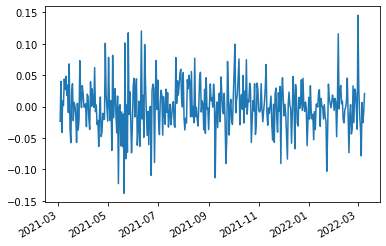

In [31]:
daily_return = close.pct_change(1).dropna()
daily_return.rename("Darily return")
daily_return.plot()
adf(daily_return)

Daily return seems perfect stationary.

We split data by 7/3 as Train/Test with sie 259/113.

In [32]:
train = daily_return[:259]
test = daily_return[259:]
test = test.rename("Test daily return")
train = train.rename("Test daily return")

In [33]:
adf(train) # training ts alse passes adf test, ie stationary.

ADF Statistic: -17.51960022008066
p-value: 4.292414618201695e-30
Critical Values:
	1%: -3.455952927706342
	5%: -2.8728086526320302
	10%: -2.572774990685656


We plot ACF and PACF to identify P,Q. However, I cannot get conclusion on P,Q from ACF and PACF plots, seen below.
Sometimes, P,Q identified only from ACF and PACF are unjustified, especially there is no support by economic meaning as
it is the case with Crypto.

<Figure size 864x576 with 0 Axes>

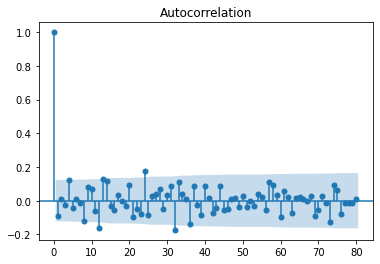

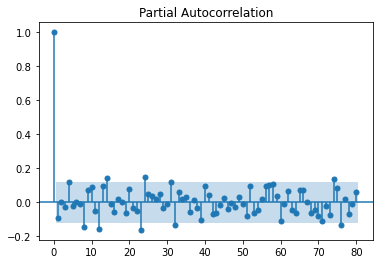

In [34]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1= sm.graphics.tsa.plot_acf(train, lags=80)
ax2 = sm.graphics.tsa.plot_pacf(train, lags=80)

Nevertheless, selection optimal P,Q based on AIC is still worth a try.

In [35]:
from pmdarima.arima import auto_arima

model = auto_arima(train, start_p=1, start_q=1,
                      test='adf',
                      max_p=30, max_q=30,
                      m=1,
                      d=1,
                      seasonal=True,
                      start_P=0,
                      D=None,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-722.351, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-810.771, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-724.351, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-839.221, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-872.491, Time=0.10 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-876.854, Time=0.11 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-881.174, Time=0.18 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=-883.281, Time=0.22 sec
 ARIMA(7,1,0)(0,0,0)[0] intercept   : AIC=-881.285, Time=0.30 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=-896.131, Time=0.39 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-906.632, Time=0.34 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-909.957, Time=0.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-

In [36]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  259
Model:               SARIMAX(4, 1, 1)   Log Likelihood                 461.978
Date:                Tue, 08 Mar 2022   AIC                           -909.957
Time:                        21:47:18   BIC                           -885.086
Sample:                             0   HQIC                          -899.956
                                - 259                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.548e-05      0.000     -0.200      0.841      -0.000       0.000
ar.L1         -0.0651      0.079     -0.822      0.411      -0.221       0.090
ar.L2          0.0075      0.082      0.091      0.927      -0.152       0.167
ar.L3         -0.0186      0.084     -0.221      0.825      -0.183       0.146
ar.L4          0.1088      0.058      1.874      0.061      -0.005       0.222
ma.L1         -0.9578      0.033    -29.198      0.000      -1.022      -0.893
sigma2         0.0017      0.000     12.585      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):                10.25
Prob(Q):                              0.55   Prob(JB):                         0.01
Heteroskedasticity (H):               0.68   Skew:                             0.07
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The selection gives us an optimal model ARIMA(4,1,1), though only coefficient of MA1 is significant...
Well, better than nothing. Let's try to predict daily return using this model and compare with the actual ts.

Unsurprisingly, prediction is poor as below plot shows. I also calculate

<AxesSubplot:>

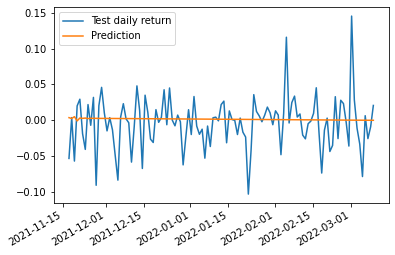

In [44]:
test_size = 113
prediction, confint = model.predict(n_periods=test_size, return_conf_int=True)
prediction = pd.Series(prediction, name = "Prediction", index = dates[259:])
compare = pd.concat([test, prediction], axis=1)
compare.plot()

Numerize the fitness of model using MSE, mean sqaured error, the result is 0.0013, not bad actually.
However, the model ARIMA(4,1,1) does not convince me unless more test justify it.

In [45]:
from sklearn.metrics import mean_squared_error as MSE
MSE(test, prediction)

0.0012959777032564835

There are some attempts which might be irrelavant* below.

In [ ]:
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
mod_autor = AutoReg(train, 26, old_names=False)
res = mod_autor.fit()
print(res.summary())

In [ ]:
sel = ar_select_order(train, 24, "bic",
                      old_names=False)
sel.ar_lags
res = sel.model.fit()
print(res.summary())

In [ ]:
# ARIMA(0,0,1)
mod = sm.tsa.arima.ARIMA(train, order=(0, 0, 1))
res = mod.fit()
print(res.summary())

In [ ]:
# ARIMA(1,0,1)
mod = sm.tsa.arima.ARIMA(train, order=(1, 0, 1))
res = mod.fit()
print(res.summary())


In [ ]:
from scipy import stats
def transformation(ts):
    data_log = pd.Series(np.log(ts), name = "Log Trans")
    dates = ts.index
    data_bc = stats.boxcox(ts)
    data_bc = pd.Series(data_bc[0],name="Box-Cox Trans")
    data_bc = data_bc.set_axis(dates, axis=0)
    data_trans = pd.concat([data_log, data_bc],axis=1)
    return data_trans

In [ ]:
trans_close = transformation(close)

In [ ]:
adf(trans_close)

Ref:
- Auto ARIMA selection package: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html
- Econometrics basics
